### Dr. Liao's AI Music Research Coding Series 
## Multimodal Lyric-Rhythm Matching (MLRM) for One Song
<hr>
<b>Author</b>: Duoduo Liao & Callie Liao <br>
<u>History</u>: <br>
--- V1.0 ------<br>
10/26/2022: V1.0 - Build the first version based on Liao_DSM_OneSong_v2.5_funcs<br>
10/26/2022: <b>Great progress! Optimzed algorithms and improve matching and alignment accuracies. </b> <br>
1) Added Rhythm Alignment -- SearchBuffer(), SeqMatching(), SeqAlignment(); <br>
2) Get all strong beats and corresponding pattern; <br>
3) Also added DTW and found my alignment algorithm are much better than DTW! (comparing code in Liao_music_sync_DTW.ipynb) <br>
--- V1.5 ------<br>
4) Added get_strong_beats_pattern(), preproc_text() & CosineSimilarity() <br>
5) revised all string '1'/'0' to binary number 1/0 for vectorization <br>
--- V2.0 ------<br>
10/28/2022: great improvement on accuracy! <br>
1) Directly match pronunables to the music strong beats.  <br>
2) Optimzed the part 3 - Matching check algorithms <br>
--- V2.5 ------<br>
10/28/2022: great improvement on accuracy! <br>
1) Functions matched with ALL SONGS' version <br>
2) Optimzed the part 2 -- timethreshold setting, customized stopwords, SeqMatching, etc. <br>
--- V3.0 ------<br>
11/26/2022 (Callie): <br>
1) Added two functions: merge_syll_to_words(), build_keywords_pattern() <br>
2) Optimized keywords pattern building (directly from words, using build_keywords_pattern()) <br>
3) merge_syll_to_words(): Merges syllable-based word list into a word-based word list. <br>
4) merge_syll_to_words() is used to produce the list pron_word_strongbeat_pattern, which shows whether each word is on a strong beat or not. <br>
11/28/2022: <br>
1) Modifed customize_stopwords() by adding customized stopwords. <br>
--- V3.5 ------<br>
11/29/2022: <br>
1) Modified get_stress_pattern() by adding counting the # of syllables for each word and put into a list, syll_num_list. <br>
2) Wrote the new merge_syll_to_words(syll_pattern, syll_num_list) based on syll_num_list. <br>
3) Modified find_keywords_from_lyrics() to get the keyword pattern directly from lyrics. <br>

<hr>

<hr>

# Part 1: Find the syllable strong beats in the song and music

## Import libraries

In [650]:
#!pip install librosa
#!pip install pretty_midi

In [651]:
import os
import pandas as pd
import numpy as np, scipy
from ipywidgets import interact
import IPython.display as ipd

# For audio processing
import librosa
import pretty_midi

# For plotting
import mir_eval.display
import librosa.display
import matplotlib.pyplot as plt
%matplotlib inline

# For text processing
import nltk
from nltk.stem import PorterStemmer
import pronouncing
import pyphen

In [652]:
# find the data path
#working_path = os.getcwd()
data_path = 'C:\\Datasets\\MIR\\CSD\\english\\'
#path = working_path + data_path
path = data_path

In [653]:
#song_filename = 'en003a'
song_filename = 'en005a'  # Butterfly Butterfly
#song_filename = 'en004a'
#song_filename = 'en009a'

#song_filename = 'en024a'
#song_filename = 'en045a'
#song_filename = 'en047a'

## Load the metadata json file

In [654]:
def load_metadata(meta_filename):   
    df_meta = pd.read_json(meta_filename, orient='records')
    df_meta = df_meta.transpose()
    return df_meta

In [655]:
df_meta = load_metadata(path+'metadata.json')
df_meta.head(5)

,songname,key_diff,tempo,time_signature
en001a,Alphabet,0,100,4/4
en001b,Alphabet,-3,100,4/4
en002a,Angels we have heard on high,0,111,4/4
en002b,Angels we have heard on high,-4,111,4/4
en003a,Three bears,0,115,4/4


In [656]:
# display the metadata info for one song 
df_meta.loc[song_filename]

songname          Butterfly
key_diff                  0
tempo                    65
time_signature          4/4
Name: en005a, dtype: object

## Get the basic music info

In [657]:
def get_meta_info(song_filename):   
    # get the info of tempo, time signature, and beats from the metadata.
    meta_tempo = df_meta.loc[song_filename]['tempo']
    time_sig = df_meta.loc[song_filename]['time_signature']
    return meta_tempo, time_sig

In [658]:
meta_tempo, time_sig = get_meta_info(song_filename)
print(meta_tempo, time_sig)

65 4/4


In [659]:
# get the numerator of the time signature
def get_time_sig_num(time_sig):
    time_sig_num = int(time_sig[0])
    return time_sig_num

In [660]:
time_sig_num = get_time_sig_num(time_sig)
print(time_sig_num)

4


## Load the file of syllable timeframes

In [661]:
def load_syllable_timeframes(filename):
    df_syllable_timeframes = pd.read_csv(filename)
    
    # Add one column for index   
    df_syllable_timeframes = df_syllable_timeframes.reset_index()
    
    return df_syllable_timeframes

In [662]:
syll_timeframe_filename = path +'csv\\' + song_filename +'.csv'
df_syllable_timeframes = load_syllable_timeframes(syll_timeframe_filename)
print(len(df_syllable_timeframes))
df_syllable_timeframes.head() 

106


,index,start,end,pitch,syllable
0,0,3.6923,4.1538,72,b_ao
1,1,4.1538,4.3846,69,t_er
2,2,4.6154,5.0769,69,f_l_ai
3,3,5.5385,6.0000,70,b_ao
4,4,6.0000,6.2308,67,t_er


## Beat and Syllable Matching

### load the wav file

In [663]:
wav_file = path + 'wav\\' + song_filename +'.wav'

In [664]:
# load the wave file and get vocal data and the sampling rate
vocal_data, sampling_rate = librosa.load(wav_file)

(-1.0, 1.0)

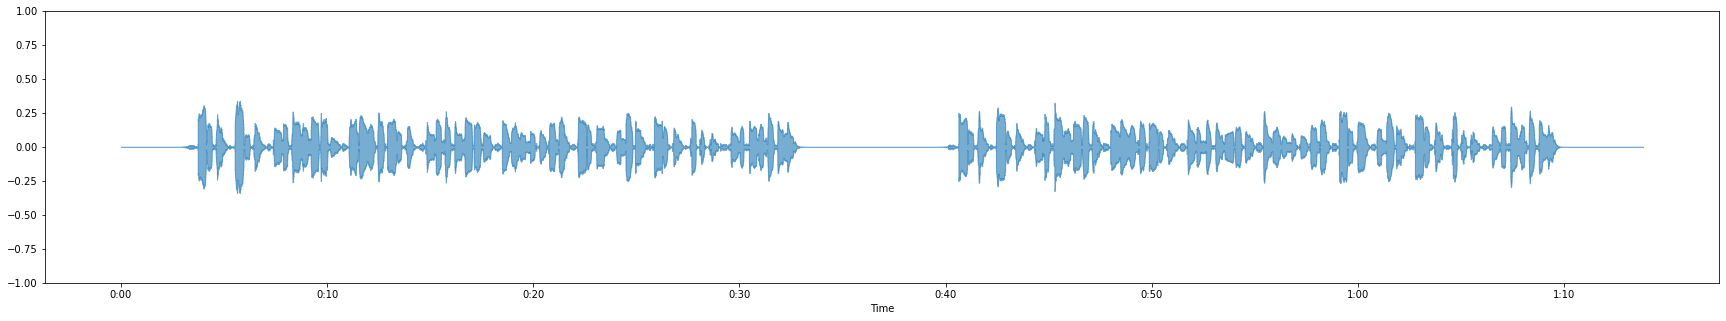

In [665]:
# Plot the wave form
plt.figure(figsize=(30, 5))
librosa.display.waveshow(vocal_data, sr=sampling_rate, alpha=0.6)
plt.ylim(-1, 1)

## Get all vocal beats 
### Detect the beat locations and global tempo

In [666]:
# onset detection and dynamic programming
vocal_tempo, vocal_beats = librosa.beat.beat_track(vocal_data, sr=sampling_rate, start_bpm=meta_tempo, units='time')

# start bpm with the tempo defined in the audio file
#tempo, beat_times = librosa.beat.beat_track(data, sr=sampling_rate, start_bpm=df.loc[wav_filename]['tempo'], units='time')

print('\nGlobal vocal temp: ', vocal_tempo)

C:\Users\eflower\AppData\Local\Temp\ipykernel_12032\162439259.py:2: FutureWarning: Pass y=[-5.5692808e-06  5.8036348e-06  1.3454907e-06 ...  1.1420988e-05
 -8.9924779e-06 -4.0140844e-06] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  vocal_tempo, vocal_beats = librosa.beat.beat_track(vocal_data, sr=sampling_rate, start_bpm=meta_tempo, units='time')



Global vocal temp:  66.25600961538461


In [667]:
print('\n# of vocal beats: ', len(vocal_beats))
#print('\nAll vocal beat times: \n', vocal_beats)


# of vocal beats:  71


### Plot the beat locations over the waveform:

(-1.0, 1.0)

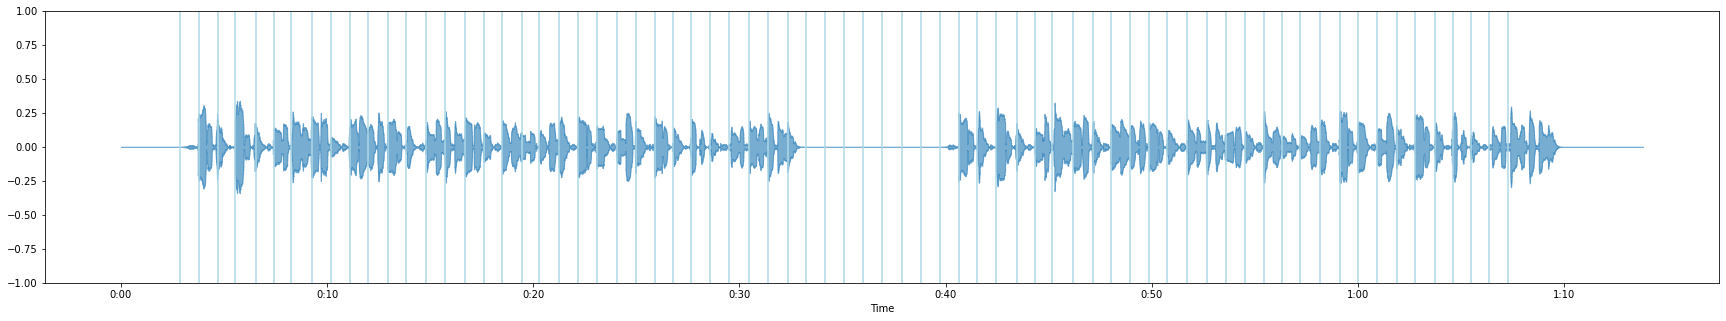

In [668]:
plt.figure(figsize=(30, 5))
librosa.display.waveshow(vocal_data, sr=sampling_rate, alpha=0.6)
plt.vlines(vocal_beats, -1, 1, color='lightblue')
plt.ylim(-1, 1)

## Get music downbeats from the MIDI file

### Load a midi file and get the basic midi info

In [669]:
midi_file = path + 'mid\\' + song_filename +'.mid'

In [670]:
# Load MIDI file into PrettyMIDI object
pm = pretty_midi.PrettyMIDI(midi_file)

# Get the length of the MIDI file
length = pm.get_end_time()

# get the estimate tempo
midi_tempo = pm.estimate_tempo()

print('The total estimate midi tempo: ', midi_tempo)
print('The total length of midi time: ', length)
print('There are {} time signature changes', len(pm.time_signature_changes))
print('There are {} instruments', len(pm.instruments))
print('Instrument 1 has {} notes', len(pm.instruments[0].notes))

The total estimate midi tempo:  117.00011700011686
The total length of midi time:  69.69223799999999
There are {} time signature changes 1
There are {} instruments 1
Instrument 1 has {} notes 106


In [671]:
pretty_midi

<module 'pretty_midi' from 'C:\\Users\\eflower\\anaconda3\\lib\\site-packages\\pretty_midi\\__init__.py'>

### Set the time threshold

In [672]:
def get_time_threshold(tempo, time_sig):
    
    time_sig_num = get_time_sig_num(time_sig)
    
    if(time_sig_num == 3):
        factor = 2
    else:
        factor = 1
    
    #Set the time threshold to be the one beat time frame based on the tempo and time signature
    time_threshold = (60/tempo/time_sig_num)/factor
    
    return time_threshold
    

In [673]:
#tempo = meta_tempo
tempo = vocal_tempo
#tempo = midi_tempo # way too off for CSD dataset
time_threshold = get_time_threshold(tempo, time_sig)
print(time_sig, time_threshold)

4/4 0.22639455782312926


### Get music beats

In [674]:
# Get downbeat times
music_beats = pm.get_beats()
print('# of beats: ', len(music_beats))
#print("All music beats\n", music_beats)

# of beats:  76


(-1.0, 1.0)

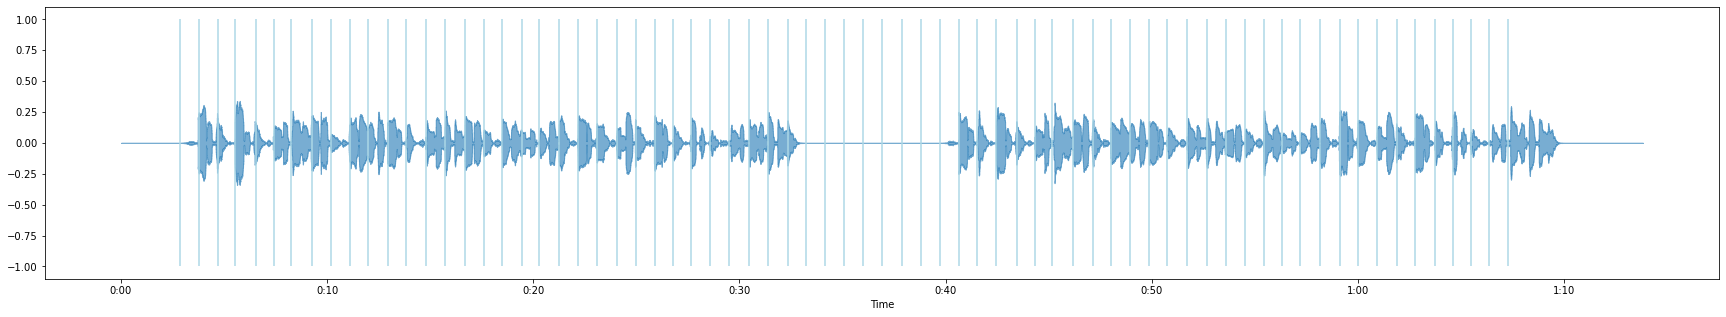

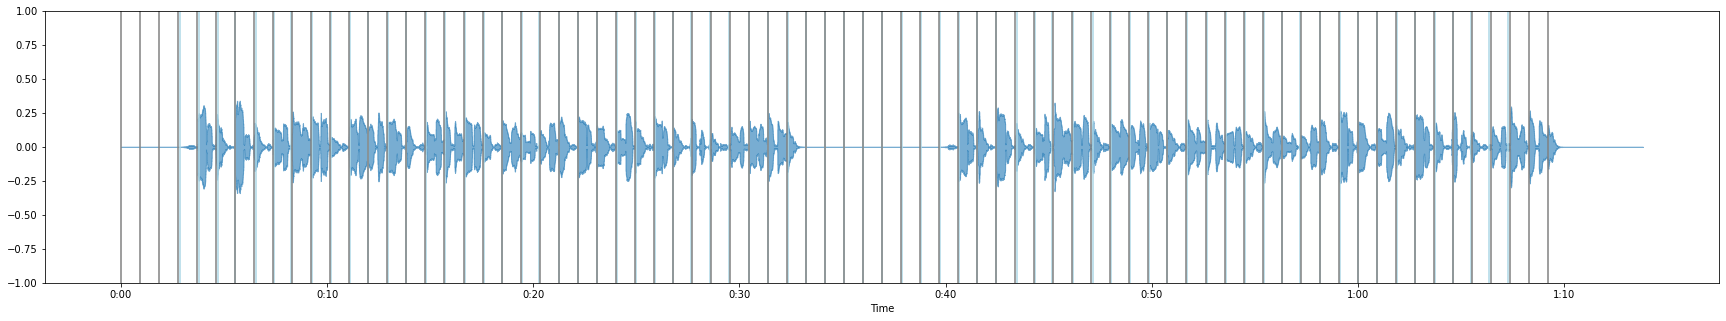

In [675]:
plt.figure(figsize=(30, 5))
librosa.display.waveshow(vocal_data, sr=sampling_rate, alpha=0.6)
plt.vlines(vocal_beats, -1, 1, color='lightblue')

plt.figure(figsize=(30, 5))
librosa.display.waveshow(vocal_data, sr=sampling_rate, alpha=0.6)
plt.vlines(vocal_beats, -1, 1, color='lightblue')
plt.vlines(music_beats, -1, 1, color='gray')
plt.ylim(-1, 1)

### Plot music beats and the piano roll

In [676]:
### define a function to plot the piano roll
def plot_piano_roll(pm, start_pitch, end_pitch, fs=60):
    # Use librosa's specshow function for displaying the piano roll
    librosa.display.specshow(pm.get_piano_roll(fs)[start_pitch:end_pitch],
                             hop_length=1, sr=fs, x_axis='time', y_axis='cqt_note',
                             fmin=pretty_midi.note_number_to_hz(start_pitch))

In [677]:
def plot_piano_roll_beat(pm, beats, color1='#AAAAAA'):
    plt.figure(figsize=(25, 4))
    plot_piano_roll(pm, 48, 84)
    ymin, ymax = plt.ylim()

    # Plot beats as cgrey lines, downbeats as white lines
    mir_eval.display.events(beats, base=ymin, height=ymax, color=color1)

    # Only display 20 seconds for clarity
    plt.xlim(0, pm.get_end_time());

C:\Users\eflower\anaconda3\lib\site-packages\librosa\util\decorators.py:88: UserWarning: Frequency axis exceeds Nyquist. Did you remember to set all spectrogram parameters in specshow?
  return f(*args, **kwargs)


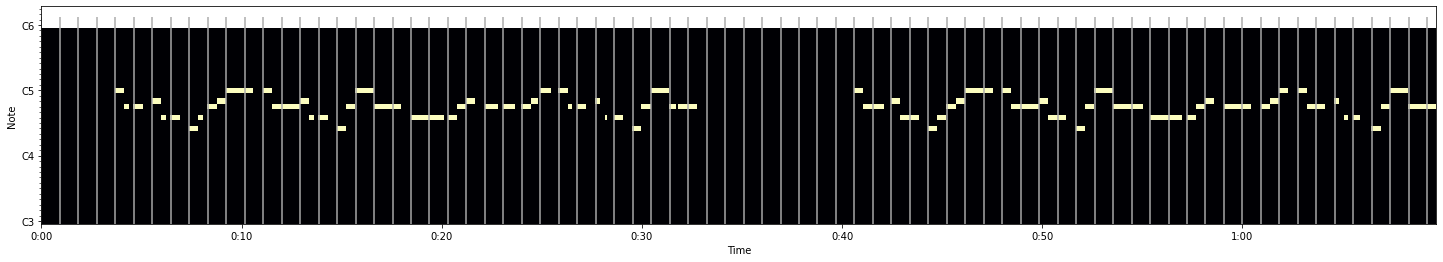

In [678]:
plot_piano_roll_beat(pm, music_beats)

In [679]:
def plot_piano_roll_beats(pm, beats, downbeats, color1='#AAAAAA', color2='#FF0000'):
    plt.figure(figsize=(25, 4))
    plot_piano_roll(pm, 48, 84)
    ymin, ymax = plt.ylim()

    # Plot beats as cgrey lines, downbeats as white lines
    mir_eval.display.events(beats, base=ymin, height=ymax, color=color1)
    #mir_eval.display.events(downbeats, base=ymin, height=ymax, color='#FFFFFF', lw=2)
    mir_eval.display.events(downbeats, base=ymin, height=ymax, color=color2, lw=2)

    # Only display 20 seconds for clarity
    plt.xlim(0, pm.get_end_time());

In [680]:
def plot_piano_roll_beats2(pm, beats, downbeats, color1='#AAAAAA', color2='#FF0000'):
    plt.figure(figsize=(25, 4))
    plot_piano_roll(pm, 48, 84)
    ymin, ymax = plt.ylim()

    # Plot beats as cgrey lines, downbeats as white lines
    mir_eval.display.events(beats, base=ymin, height=ymax, color=color1)
    mir_eval.display.events(downbeats, base=ymin, height=ymax, color=color2, lw=2)

    # Only display the whole length for clarity
    plt.xlim(0, pm.get_end_time());

### Get music downbeats from the MIDI

In [681]:
# Get downbeat times
music_downbeats = pm.get_downbeats()
print('# of downbeats: ', len(music_downbeats))
print("Downbeats \n", music_downbeats)

# of downbeats:  19
Downbeats 
 [ 0.        3.692304  7.384608 11.076912 14.769216 18.46152  22.153824
 25.846128 29.538432 33.230736 36.92304  40.615344 44.307648 47.999952
 51.692256 55.38456  59.076864 62.769168 66.461472]


### Get all music downbeats 

In [682]:
# Get all downbeat times
def get_downbeats(beats, time_sig): 
    
    time_sig_num = get_time_sig_num(time_sig)
   
    # get the interval of two downbeats
    if(time_sig_num == 4):
        interval = 4  # only downbeat (1st strongest beat)
    elif time_sig_num == 3:
        interval = 3
    else:
        interval = 2
        
    all_downbeats = []
    for i in range(len(beats)):
        if i%interval ==0:
            all_downbeats.append(beats[i])
    
    return all_downbeats        

### Get music strong beats (including 2nd strong beats in measures)

In [683]:
# Get all strong beat times
def get_strongbeats(beats, time_sig): 
    
    time_sig_num = get_time_sig_num(time_sig)
   
    # get the interval of two downbeats
    if(time_sig_num == 4):
        interval = 2
    elif time_sig_num == 3:
        interval = 3
    else:
        interval = 2
        
    all_strong_beats = []
    for i in range(len(beats)):
        if i%interval ==0:
            all_strong_beats.append(beats[i])
    
    return all_strong_beats        
 

In [684]:
#music_strong_beats = get_strongbeats(music_beats, time_sig)
#print('# of all downbeats: ', len(music_strong_beats))
#print("All downbeats\n", music_strong_beats)

### Get all kinds of beats from the MIDI file  (integrated version)

In [685]:
def get_midi_beats(song_filename, vocal_beats, time_sig, plot=False, print_flag=False):
    # Load a midi file
    midi_file = path + 'mid\\' + song_filename +'.mid'
    pm = pretty_midi.PrettyMIDI(midi_file)

    music_beats = pm.get_beats() # Get midi beat times
    music_downbeats = pm.get_downbeats() # Get midi downbeat times
    if(print_flag):
        print('# of midi music beats:', len(music_beats), '   # of midi downbeats:', len(music_downbeats))

    # get all music downbeats 
    music_strong_beats = get_strongbeats(music_beats, time_sig)
    if(print_flag):
        print('# of all midi downbeats: ', len(music_downbeats))

    if(plot):
        plot_piano_roll_beats(pm, music_beats, music_downbeats)
        plot_piano_roll_beats(pm, music_beats, music_strong_beats)
        plot_piano_roll_beats(pm, music_beats, vocal_beats, color1='#DDDDDD', color2='#00AAAA')
    
    return music_beats, music_downbeats, music_strong_beats

# of midi music beats: 76    # of midi downbeats: 19
# of all midi downbeats:  19


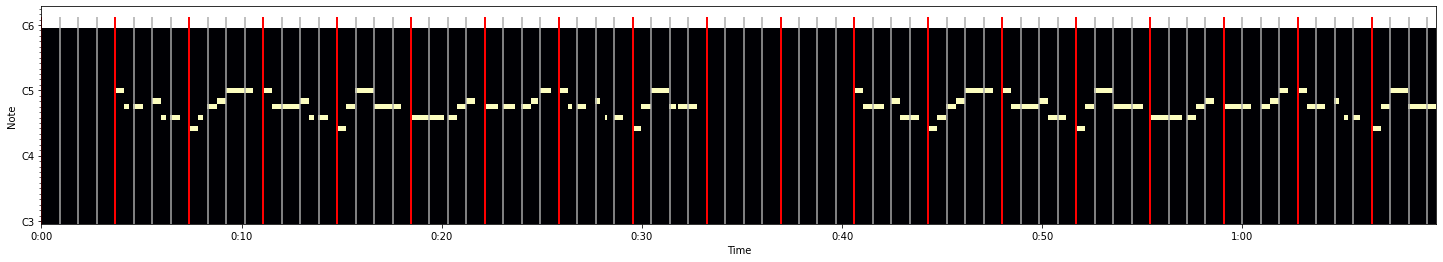

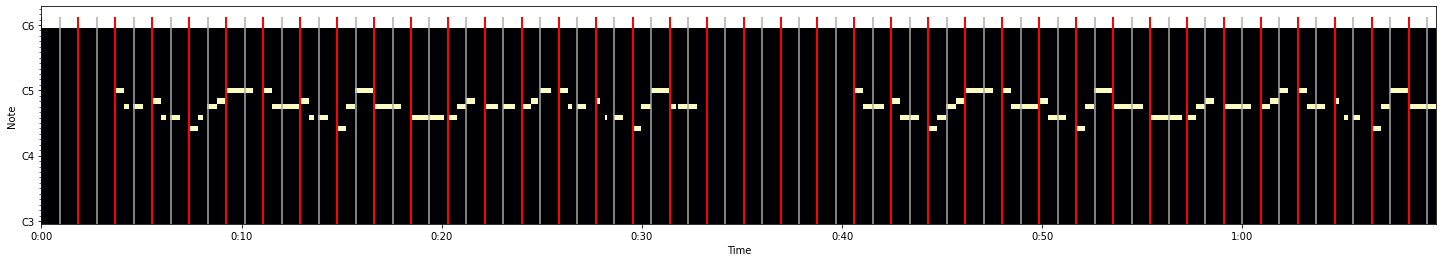

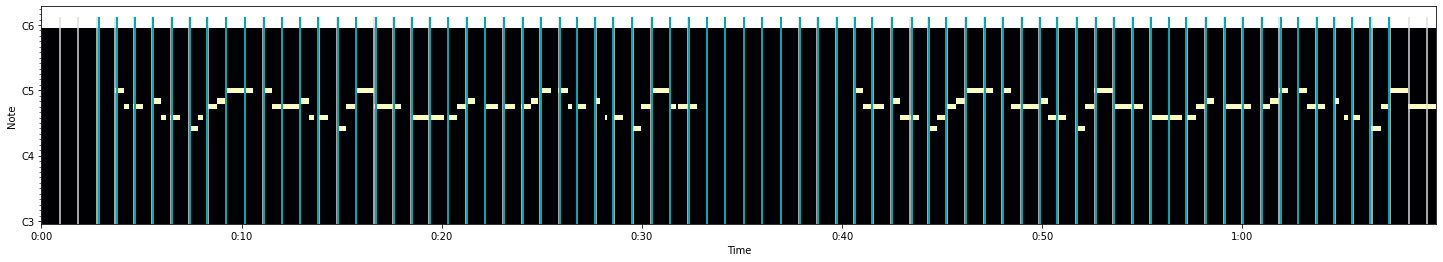

In [686]:
music_beats, music_downbeats, music_strong_beats = get_midi_beats(song_filename, vocal_beats, time_sig, plot=True, print_flag=True)

## vocal strong beat alignment with syllables
### Some general basic functions 

In [687]:
def determine_equal_time(t1, t2, threshold=0.05):
    dt = threshold
    if (t1 >= t2 - dt) & (t1 <= t2 + dt):
        return True
    else:
        return False

In [688]:
from collections import Counter

def count_values(seq, key):
    count_dict = dict(Counter(seq))
    if count_dict:
        if count_dict.get(key) is not None:
            return count_dict[key]
        else:
            return 0
    else:
        return 0

In [689]:
# Plot piano roll and three kinds of beats
def plot_piano_roll_beats3(pm, beats1, beats2, beats3):
    plt.figure(figsize=(25, 4))
    plot_piano_roll(pm, 48, 84)
    ymin, ymax = plt.ylim()

    # Plot beats as grey lines, downbeats as white lines
    mir_eval.display.events(beats1, base=ymin, height=ymax, color='#AAAAAA')
    mir_eval.display.events(beats2, base=ymin, height=ymax, color='#FFFFFF', lw=2)
    mir_eval.display.events(beats3, base=ymin, height=ymax, color='#FF0000', lw=2)

    # Only display 20 seconds for clarity
    plt.xlim(0, pm.get_end_time());

### 1. Sequence Matching and Rhythm Alignment

#### Search points within the buffer from the input sequence

In [690]:
null_value = -9999

def SearchBuffer(point, seq, threshold):
    
    buf_ind = []
    buf_value = []
    buf_dist = []
    flag = False
    for i in range(len(seq)):
        if determine_equal_time(point, seq[i], threshold):
            buf_ind.append(i)
            buf_value.append(seq[i])
            buf_dist.append(abs(point - seq[i]))           
            flag = True
    
    if(flag == False):
        buf_ind.append(-1)
        buf_value.append(null_value)
        buf_dist.append(0.0)

    return buf_ind, buf_value, buf_dist

In [691]:
buf_ind, buf_value, buf_dist = SearchBuffer(100, music_beats, 0.1)
buf_ind, buf_value, buf_dist

([-1], [-9999], [0.0])

In [692]:
buf_ind[np.argmin(buf_dist)]

-1

#### Sequence Matching
Find the indices and values of the Sequence 1 matched with Sequence 2.

In [693]:
def set_time_threshold(interval, time_sig):
    
    time_sig_num = get_time_sig_num(time_sig)
    
    # get the factor 
    if(time_sig_num == 4):
        factor = 5
    elif time_sig_num == 3:
        factor = 3
    else:
        factor = 5
    
    # set dynamic threshold 
    time_threshold = float(interval/factor)

    return time_threshold
    

In [694]:
# Sequence Matching 
# Match seq1 with seq2. Output matching index list for seq1. If matched, input the index of seq1 into the matching list. If not, put -1.
def SeqMatching(seq1, seq2, time_sig):
    
    # calcuate the interval from seq2
    interval = seq2[1]-seq2[0]

    # set dynamic threshold related to seq2
    time_threshold = set_time_threshold(interval, time_sig)

    
    dt = time_threshold  # set the time threshold  
    
    ind_list = []     
    value_list = []

    for i in range(len(seq1)): # seq1
        buf_ind, buf_value, buf_dist = SearchBuffer(seq1[i], seq2, dt)
        # find the the index in the seq2 with the minimum distance        
        min_index = np.argmin(buf_dist)
        # interpolation: insert the matched index
        matched_index = buf_ind[min_index]
        ind_list.append(buf_ind[min_index])   
        value_list.append(seq2[matched_index])
                
    # return the matching index list for seq2
    return ind_list, value_list

#### Sequence Alignment
Align Sequence 1 with Sequence 2. Use linear interpolations to handle both unmatched and missing points.

In [695]:
# Rhythm Alignment 
# use linear interpolation to handle unmatched beats (index = -1) and missing beats which two neighour points are not sequential. 
def SeqAlignment(seq1, seq2, time_sig):

    # calcuate the interval from seq2
    interval = seq2[1]-seq2[0]
    
    # find the matched sequence indices and values
    ind_list, value_list = SeqMatching(seq1, seq2, time_sig)
    #print(interval)
    start_ind = ind_list[0]
    
    # Handle unmatched points with linear interploation for Seq1  
    for i in range(len(ind_list)): 
        if(ind_list[i] == -1):
            value_list[i] = (start_ind+i)*interval
            ind_list[i] = i
            #print(i, value_list[i])

    # Handle missing points with linear interploation for Seq1  
    for i in range(len(ind_list)-1): 
        if(ind_list[i] >= 0):
            k = ind_list[i+1] - ind_list[i]
            for j in range(k):
                value_list.insert(i+j+2, (start_ind+i+j+1)*interval)
                #print(i+j+1, value_list[i+j+1])
            
    # return the matching index list and the aligned value list
    return ind_list, value_list

### Beat Alignment - Align vocal and music beats
##### 1) Match vocal beats with music beats

In [696]:
matched_vocal_ind, matched_vocal_beats = SeqMatching(vocal_beats, music_beats, time_sig)
print(len(matched_vocal_ind))
#print(count_values(matched_vocal_ind, -1))
print(matched_vocal_ind)
#print(len(matched_vocal_beats))
#print(matched_vocal_beats)
#print(music_beats)

71
[3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73]


##### 2) Align vocal beats with music beats

In [697]:
aligned_vocal_ind, aligned_vocal_beats = SeqAlignment(vocal_beats, music_beats, time_sig)
print(len(aligned_vocal_ind))
print(aligned_vocal_ind)

71
[3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73]


##### 3) plots

(-1.0, 1.0)

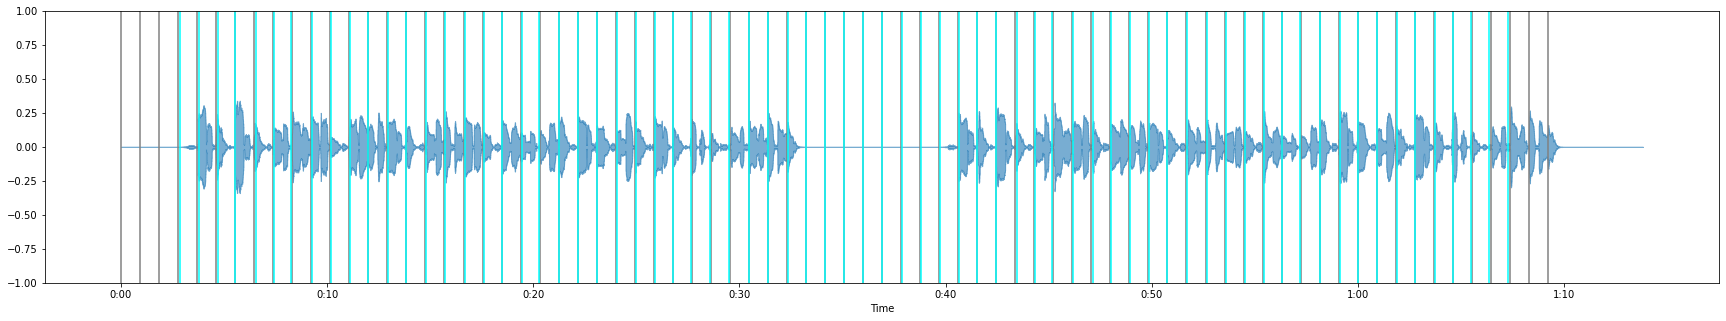

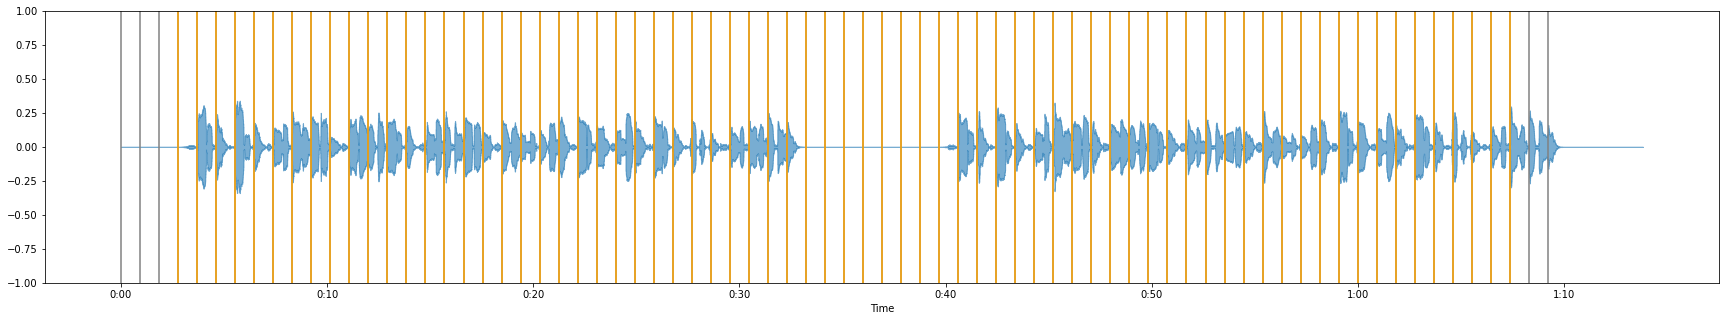

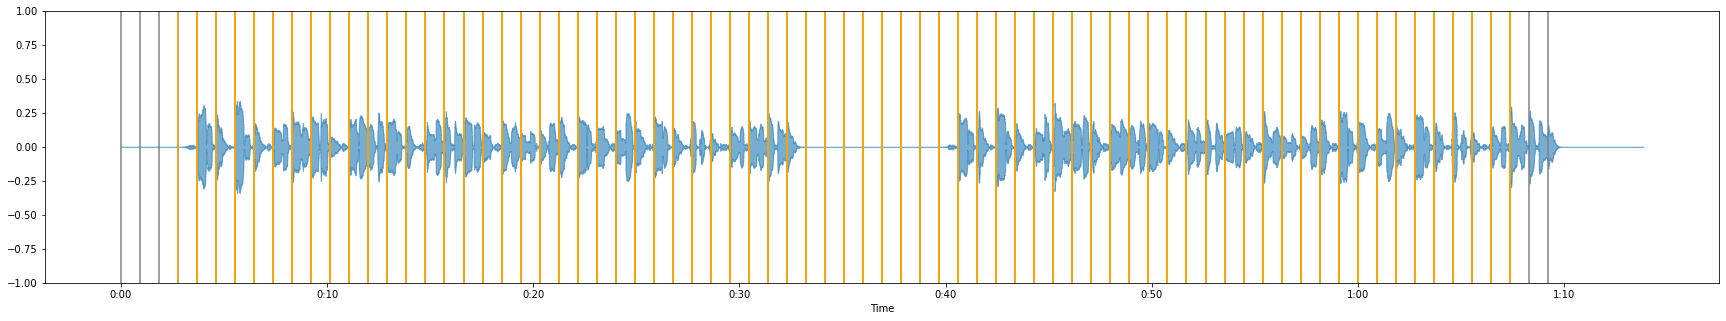

In [698]:
# original unaligned vocal beats vs. music beats
plt.figure(figsize=(30, 5))
librosa.display.waveshow(vocal_data, sr=sampling_rate, alpha=0.6)
plt.vlines(music_beats, -1, 1, color='gray')
plt.vlines(vocal_beats, -1, 1, color='cyan')
plt.ylim(-1, 1)

# matched vocal beats vs. music beats
plt.figure(figsize=(30, 5))
librosa.display.waveshow(vocal_data, sr=sampling_rate, alpha=0.6)
plt.vlines(music_beats, -1, 1, color='gray')
plt.vlines(matched_vocal_beats, -1, 1, color='orange')
plt.ylim(-1, 1)

# aligned vocal beats vs. music beats
plt.figure(figsize=(30, 5))
librosa.display.waveshow(vocal_data, sr=sampling_rate, alpha=0.6)
plt.vlines(music_beats, -1, 1, color='gray')
plt.vlines(aligned_vocal_beats, -1, 1, color='orange')
plt.ylim(-1, 1)

### 2.  Pronunable Matching
Match all vocal pronunables in the beat timeframes to the music MIDI strong beats

#### Get start times of all vocal pronunables from the beat timeframes in the csv file.

In [699]:
vocal_syllable_times = df_syllable_timeframes["start"].values.tolist()
print("vocal syllable times #: ", len(vocal_syllable_times))
print("vocal beats #:", len(vocal_beats))

vocal syllable times #:  106
vocal beats #: 71


#### Get length of strong beats

In [700]:
len(music_beats)

76

In [701]:
len(music_strong_beats)

38

#### Match pronunables to the music beats (NOT directly used)

In [702]:
matched_pron_ind, matched_pron_beats = SeqMatching(vocal_syllable_times, music_beats, time_sig)
print(len(matched_pron_ind))
print(matched_pron_ind)
#print(matched_pron_beats)

106
[4, -1, 5, 6, -1, 7, 8, -1, 9, -1, 10, -1, 11, 12, -1, 13, -1, 14, -1, 15, 16, -1, 17, -1, 18, -1, 19, 20, -1, 21, -1, 22, -1, 23, 24, -1, 25, 26, -1, 27, 28, -1, 29, 30, -1, 31, 32, -1, 33, -1, 34, -1, 35, 44, -1, 45, 46, -1, 47, 48, -1, 49, -1, 50, -1, 51, 52, -1, 53, -1, 54, -1, 55, 56, -1, 57, -1, 58, -1, 59, 60, -1, 61, -1, 62, -1, 63, 64, -1, 65, 66, -1, 67, 68, -1, 69, 70, -1, 71, 72, -1, 73, -1, 74, -1, 75]


#### Match pronunables to the music strong beats

In [703]:
matched_pron_strongbeat_ind, matched_pron_strong_beats = SeqMatching(vocal_syllable_times, music_strong_beats, time_sig)
print(len(matched_pron_strongbeat_ind))
print(matched_pron_strongbeat_ind)
#print(matched_pron_beats)

106
[2, -1, -1, 3, -1, -1, 4, -1, -1, -1, 5, -1, -1, 6, -1, -1, -1, 7, -1, -1, 8, -1, -1, -1, 9, -1, -1, 10, -1, -1, -1, 11, -1, -1, 12, -1, -1, 13, -1, -1, 14, -1, -1, 15, -1, -1, 16, -1, -1, -1, 17, -1, -1, 22, -1, -1, 23, -1, -1, 24, -1, -1, -1, 25, -1, -1, 26, -1, -1, -1, 27, -1, -1, 28, -1, -1, -1, 29, -1, -1, 30, -1, -1, -1, 31, -1, -1, 32, -1, -1, 33, -1, -1, 34, -1, -1, 35, -1, -1, 36, -1, -1, -1, 37, -1, -1]


C:\Users\eflower\anaconda3\lib\site-packages\librosa\util\decorators.py:88: UserWarning: Frequency axis exceeds Nyquist. Did you remember to set all spectrogram parameters in specshow?
  return f(*args, **kwargs)


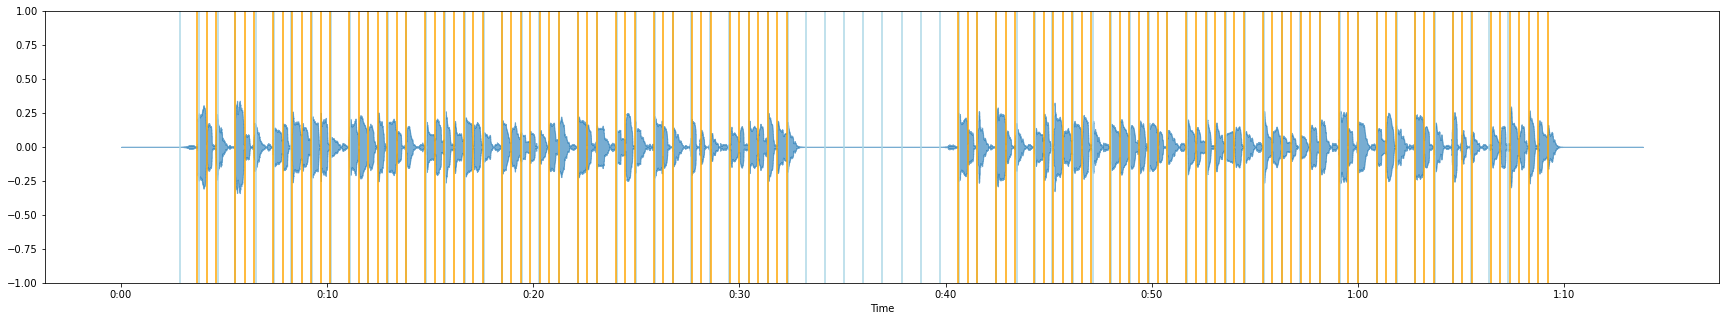

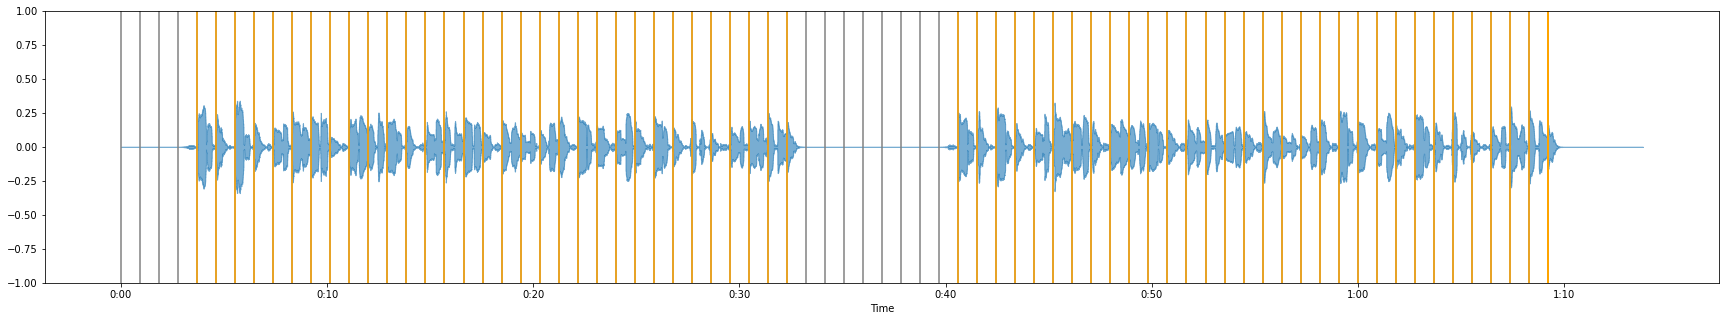

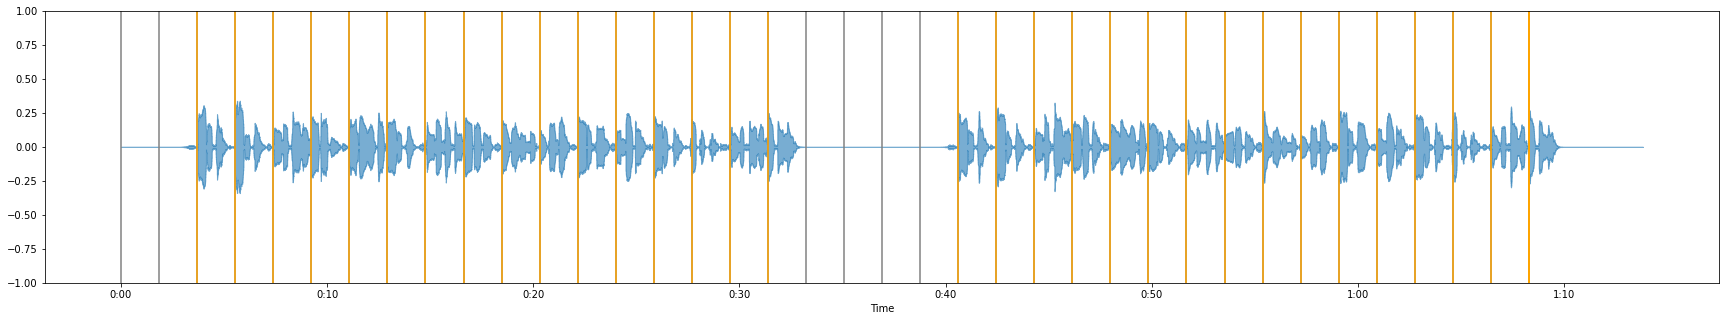

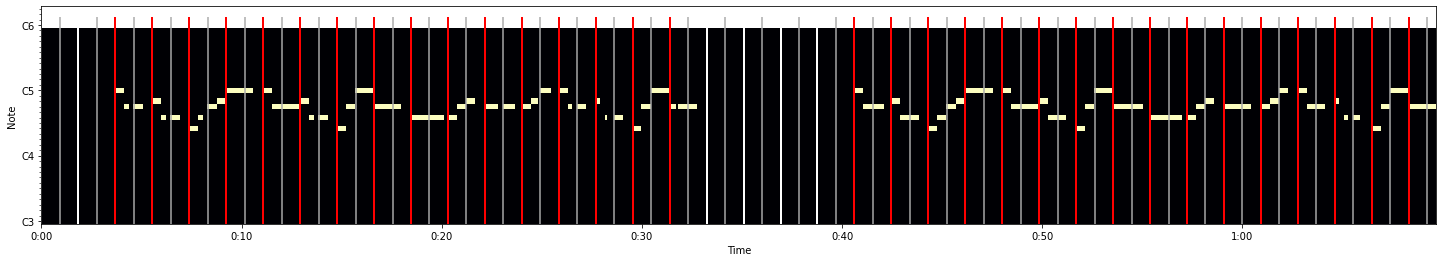

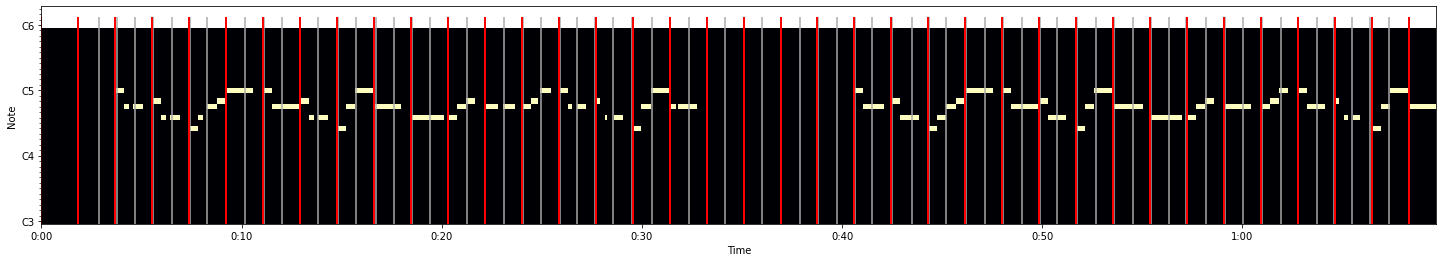

In [704]:
# original vocal syllable beats vs. vocal beats
plt.figure(figsize=(30, 5))
librosa.display.waveshow(vocal_data, sr=sampling_rate, alpha=0.6)
plt.vlines(vocal_beats, -1, 1, color='lightblue')
plt.vlines(vocal_syllable_times, -1, 1, color='orange')
plt.ylim(-1, 1)

# matched vocal syllable beats vs. music beats
plt.figure(figsize=(30, 5))
librosa.display.waveshow(vocal_data, sr=sampling_rate, alpha=0.6)
plt.vlines(music_beats, -1, 1, color='gray')
plt.vlines(matched_pron_beats, -1, 1, color='orange')
plt.ylim(-1, 1)

# matched pronunable strong beats vs. music strong beats
plt.figure(figsize=(30, 5))
librosa.display.waveshow(vocal_data, sr=sampling_rate, alpha=0.6)
plt.vlines(music_strong_beats, -1, 1, color='gray')
plt.vlines(matched_pron_strong_beats, -1, 1, color='orange')
plt.ylim(-1, 1)

#plot_piano_roll_beats3(pm, vocal_beats, music_strong_beats, matched_pron_strong_beats)
plot_piano_roll_beats3(pm, music_beats, music_strong_beats, matched_pron_strong_beats) # gray, white, red
#plot_piano_roll_beats(pm, music_strong_beats, matched_pron_strong_beats)
plot_piano_roll_beats(pm, vocal_beats, music_strong_beats)

In [705]:
print(len(matched_pron_ind))
print(matched_pron_ind)

106
[4, -1, 5, 6, -1, 7, 8, -1, 9, -1, 10, -1, 11, 12, -1, 13, -1, 14, -1, 15, 16, -1, 17, -1, 18, -1, 19, 20, -1, 21, -1, 22, -1, 23, 24, -1, 25, 26, -1, 27, 28, -1, 29, 30, -1, 31, 32, -1, 33, -1, 34, -1, 35, 44, -1, 45, 46, -1, 47, 48, -1, 49, -1, 50, -1, 51, 52, -1, 53, -1, 54, -1, 55, 56, -1, 57, -1, 58, -1, 59, 60, -1, 61, -1, 62, -1, 63, 64, -1, 65, 66, -1, 67, 68, -1, 69, 70, -1, 71, 72, -1, 73, -1, 74, -1, 75]


In [706]:
print(len(matched_pron_beats))

106


In [707]:
print(len(matched_pron_strong_beats))

106


#### Get all pronunables landing on the music strong beats and the corresponding pattern (NOT dIrectly used)

In [708]:
# Get all strong beats based on the matched index list and the corresponding pattern
def get_strong_beats_pattern(beats, ind_list, time_sig): 
    
    time_sig_num = get_time_sig_num(time_sig)

    # get the interval of strong beats
    if(time_sig_num == 4):
        interval = 2
    elif time_sig_num == 3:
        interval = 3
    else:
        interval = 1
       
    pattern = []
    all_strong_beats = []
    for i in range(len(beats)):
        index = ind_list[i]
        #print(index)
        if ind_list[i]%interval ==0:
            all_strong_beats.append(beats[i])
            pattern.append(1)
        else:
            pattern.append(0)
    
    return all_strong_beats, pattern      
 

In [709]:
matched_pron_strong_beats, pron_pattern = get_strong_beats_pattern(matched_pron_beats, matched_pron_ind, time_sig)
print('# of all strong beats: ', len(matched_pron_strong_beats))
#print("All strong beats\n", matched_pron_strong_beats)
print(matched_pron_ind)
print('\n# of pronunables: ', len(pron_pattern))
print("The pronunable pattern:\n", pron_pattern)
#print(count_values(pron_pattern, 1))

# of all strong beats:  32
[4, -1, 5, 6, -1, 7, 8, -1, 9, -1, 10, -1, 11, 12, -1, 13, -1, 14, -1, 15, 16, -1, 17, -1, 18, -1, 19, 20, -1, 21, -1, 22, -1, 23, 24, -1, 25, 26, -1, 27, 28, -1, 29, 30, -1, 31, 32, -1, 33, -1, 34, -1, 35, 44, -1, 45, 46, -1, 47, 48, -1, 49, -1, 50, -1, 51, 52, -1, 53, -1, 54, -1, 55, 56, -1, 57, -1, 58, -1, 59, 60, -1, 61, -1, 62, -1, 63, 64, -1, 65, 66, -1, 67, 68, -1, 69, 70, -1, 71, 72, -1, 73, -1, 74, -1, 75]

# of pronunables:  106
The pronunable pattern:
 [1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0]


#### Convert pronunables strong beats to the pattern

In [710]:
# Get all strong beats based on the matched index list and the corresponding pattern
def get_pron_strong_pattern(ind_list, time_sig): 
    
    time_sig_num = get_time_sig_num(time_sig)    
    
    pattern = []
    for i in range(len(ind_list)):
        index = ind_list[i]
        #print(index)
        if ind_list[i] > 0:
            pattern.append(1)
        else:
            pattern.append(0)
    
    return pattern      
 

In [711]:
print(len(matched_pron_strongbeat_ind))
print(matched_pron_strongbeat_ind)

106
[2, -1, -1, 3, -1, -1, 4, -1, -1, -1, 5, -1, -1, 6, -1, -1, -1, 7, -1, -1, 8, -1, -1, -1, 9, -1, -1, 10, -1, -1, -1, 11, -1, -1, 12, -1, -1, 13, -1, -1, 14, -1, -1, 15, -1, -1, 16, -1, -1, -1, 17, -1, -1, 22, -1, -1, 23, -1, -1, 24, -1, -1, -1, 25, -1, -1, 26, -1, -1, -1, 27, -1, -1, 28, -1, -1, -1, 29, -1, -1, 30, -1, -1, -1, 31, -1, -1, 32, -1, -1, 33, -1, -1, 34, -1, -1, 35, -1, -1, 36, -1, -1, -1, 37, -1, -1]


In [712]:
pron_strong_pattern = get_pron_strong_pattern(matched_pron_strongbeat_ind, time_sig)
print('# of all matched strongbeat pronunables: ', len(matched_pron_strong_beats))
#print("All strong beats\n", matched_pron_strong_beats)
print('# of pronunables: ', len(pron_strong_pattern))
print("Pronunable strong-beat pattern:\n", pron_strong_pattern)
#print(count_values(pron_strong_pattern, 1))

# of all matched strongbeat pronunables:  32
# of pronunables:  106
Pronunable strong-beat pattern:
 [1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0]


#### plot matched vocal syllable strong beats vs. music beats

(-1.0, 1.0)

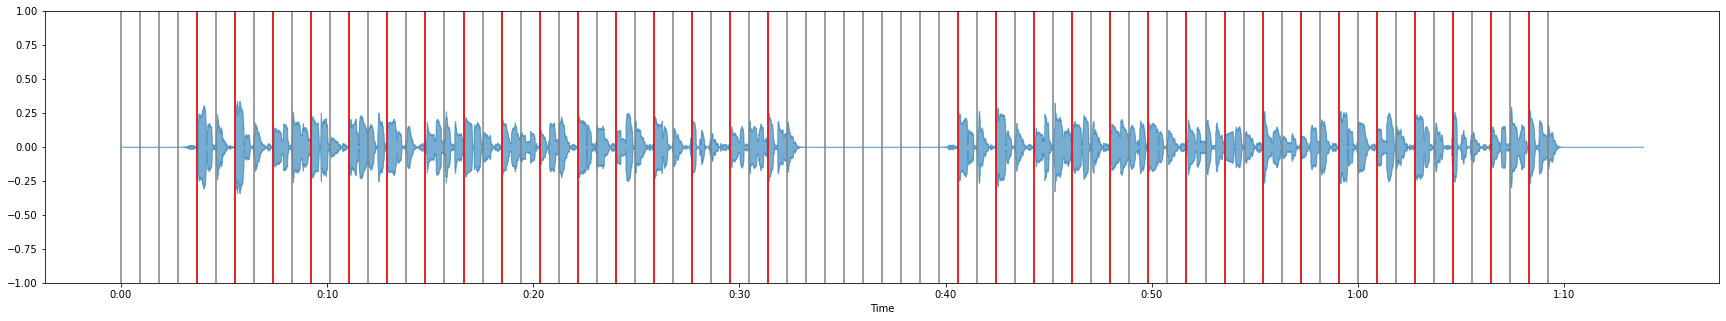

In [713]:
# matched vocal syllable strong beats vs. music beats
plt.figure(figsize=(30, 5))
librosa.display.waveshow(vocal_data, sr=sampling_rate, alpha=0.6)
plt.vlines(music_beats, -1, 1, color='gray')
plt.vlines(matched_pron_strong_beats, -1, 1, color='red')
plt.ylim(-1, 1)

C:\Users\eflower\anaconda3\lib\site-packages\librosa\util\decorators.py:88: UserWarning: Frequency axis exceeds Nyquist. Did you remember to set all spectrogram parameters in specshow?
  return f(*args, **kwargs)


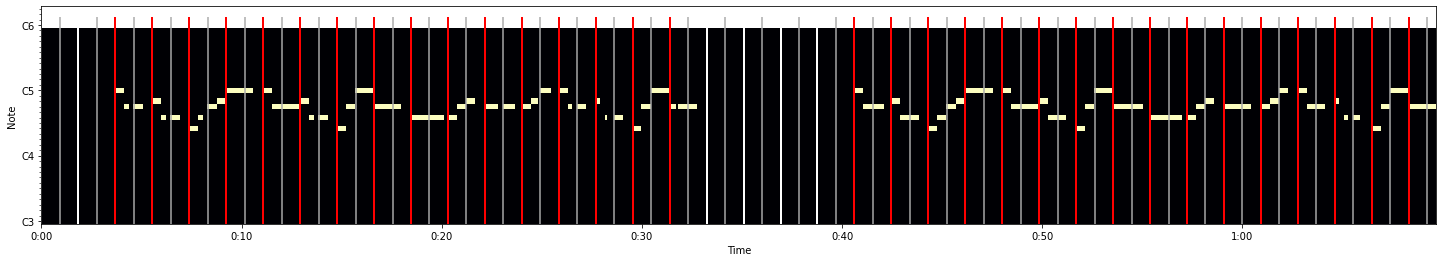

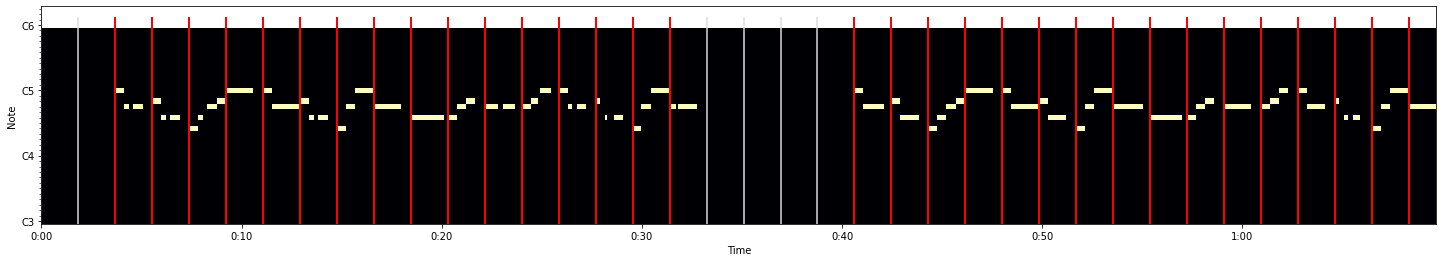

In [714]:
plot_piano_roll_beats3(pm, music_beats, music_strong_beats, matched_pron_strong_beats)
plot_piano_roll_beats2(pm, music_strong_beats, matched_pron_strong_beats, color1='#DDDDDD', color2='red')

<hr>

# Part 2: Find stressed key syllables 

## Load a lyric file 

In [715]:
def load_lyric(filename):
    fo = open(lyric_file, "r")
    lyrics = fo.read()
    return lyrics

In [716]:
lyric_file = path + 'lyric\\' + song_filename +'.txt'
lyric = load_lyric(lyric_file)

## Get stressed patterns

In [717]:
# preprocess the text  
def preproc_text(text):
    tokenizer = nltk.RegexpTokenizer(r"\w+")  
    sent_tokens = tokenizer.tokenize(text.lower())
    #print(sent_tokens)

    # words/letters to remove
    remove_wordlist = ['s', "re", "m",  "ve", "t"]
    #remove_wordlist = ["s", "re", "m", "nt", "ve", "t", "er", 'o', 'll']
 
    preproc_text = []
    for token in sent_tokens:
        if token not in remove_wordlist:
            preproc_text.append(token)
        
    return preproc_text

In [718]:
# get the stress pattern for a sentence
def get_stress_pattern(text):
    
    sent_tokens = preproc_text(text)
    
    # preprocess the input text 
    #sent_tokens = preproc_text(sentence)
    
    porter = PorterStemmer()
    dic = pyphen.Pyphen(lang='nl_NL')
    
    stress_pattern = []
    stress_pattern_wordlist = []
    
    for token in sent_tokens:
        # gets the stressed syllables order
        stress = pronouncing.stresses_for_word(token)
        # if the word exists in the CMU dict
        if(stress):
            # append the 1st variant to stress_pattern
            stress_pattern.append(stress[0])
            #print(token, ": ", stress)
        else:
            # if the word ends with "-ed"
            if (token[len(token)-2:len(token)] == "ed"):
                # stem the word
                # ("ed" is not a separate syllable)
                token = porter.stem(token)
            # use pyphen to split the word
            syll_dash = dic.inserted(token)
            # remove dashes
            syllables = syll_dash.split("-")
            # assume 1st syll is stressed
            syll_list = ["1"]
            # assume all others are non-stressed
            for i in range(len(syllables)):
                if i > 0:
                    syll_list[0] = syll_list[0] + "0"
            #print(token, "#: ", syll_list)        
            # append it to the stress_pattern
            stress_pattern.append(syll_list[0])   
        stress_pattern_wordlist.append(token)
            
    # count the number of syllables for each word
    syll_num_list = []
    for x in stress_pattern:
        syll_num_list.append(len(x))
    #print(syll_num_list)  
            
    return stress_pattern, syll_num_list, stress_pattern_wordlist

### Count the syllables
##### Calculate the actual # of syllables but don't split the acutal syllable sequence per word
example: a word that has the syllable sequence "10" will be counted twice but the sequence itself won't be altered.

In [719]:
def count_stress_pattern(stress_pattern):
    count = 0
    for i in range(len(stress_pattern)):
        #print(type(stress))
        #print(len(stress_pattern[i]), i)
        count = count + len(stress_pattern[i])
        
    return count

In [720]:
stress_pattern, syll_num_list, stress_pattern_wordlist = get_stress_pattern(lyric)
print( "Total # of words: ", len(stress_pattern_wordlist))
print("Lyrical word list: \n", stress_pattern_wordlist)
print( "\nTotal # of stress patterns: ", len(stress_pattern))
print("List of the stress patterns for each lyrical word: \n", stress_pattern)
print("\nTotal # of syllables for each lyrical word: ", len(syll_num_list)) 
print("List of # of syllables for each lyrical word: \n", syll_num_list)    

Total # of words:  80
Lyrical word list: 
 ['butterfly', 'butterfly', 'come', 'and', 'fly', 'on', 'over', 'here', 'yellow', 'and', 'white', 'butterfly', 'come', 'and', 'dance', 'on', 'over', 'here', 'â', 'on', 'a', 'windy', 'springtime', 'day', 'petals', 'smile', 'in', 'the', 'wind', 'sparrows', 'too', 'chirp', 'chirp', 'chirp', 'sing', 'a', 'song', 'and', 'dance', 'along', 'butterfly', 'butterfly', 'come', 'and', 'fly', 'on', 'over', 'here', 'yellow', 'and', 'white', 'butterfly', 'come', 'and', 'dance', 'on', 'over', 'here', 'â', 'on', 'a', 'windy', 'springtime', 'day', 'petals', 'smile', 'in', 'the', 'wind', 'sparrows', 'too', 'chirp', 'chirp', 'chirp', 'sing', 'a', 'song', 'and', 'dance', 'along']

Total # of stress patterns:  80
List of the stress patterns for each lyrical word: 
 ['102', '102', '1', '0', '1', '1', '10', '1', '10', '0', '1', '102', '1', '0', '1', '1', '10', '1', '1', '1', '0', '10', '12', '1', '10', '1', '0', '0', '1', '10', '1', '1', '1', '1', '1', '0', '1', '0', 

In [721]:
count = count_stress_pattern(stress_pattern)
count

108

### Turn the stress pattern into the bits

In [722]:
# turn strings into the binary values
def str_to_bin(str_list):
    for i in range(len(str_list)):
        if(str_list[i] == '1'):
            str_list[i] = 1
        else:
            str_list[i] = 0
    return str_list

In [723]:
def get_stress_bits(stress_pattern, stress_pattern_wordlist):
    stress_bits = []
    stress_all_bits = []
    stress_bits_wordlist = []
    for i in range(len(stress_pattern)):
        stressed_word = stress_pattern[i]
        stress_len = len(stressed_word)
        if(stress_len>1):
            for j in range(len(stressed_word)):
                stress_bits.append(stressed_word[j]) # keep the same, i.e., stressed = 1 and unstressed = 0
                stress_all_bits.append('1') # set all syllables to be 1 for a stressed word
                stress_bits_wordlist.append(stress_pattern_wordlist[i])
        else:
            stress_bits.append(stressed_word)
            stress_all_bits.append(stressed_word)
            stress_bits_wordlist.append(stress_pattern_wordlist[i])
            
    stress_bits = str_to_bin(stress_bits)
    stress_all_bits = str_to_bin(stress_all_bits)
    
    return stress_bits, stress_all_bits, stress_bits_wordlist


In [724]:
stress_bits, stress_all_bits, stress_bits_wordlist = get_stress_bits(stress_pattern, stress_pattern_wordlist)
print("Total # of lyrics:", len(stress_bits_wordlist))
print("Word list: \n", stress_bits_wordlist)
print("\nTotal # of syllables:", len(stress_bits))
print("Stress flag list of lyrical syllables (split up stress patterns): \n", stress_bits, "\n")
print(len(stress_all_bits))
print(stress_all_bits)

Total # of lyrics: 108
Word list: 
 ['butterfly', 'butterfly', 'butterfly', 'butterfly', 'butterfly', 'butterfly', 'come', 'and', 'fly', 'on', 'over', 'over', 'here', 'yellow', 'yellow', 'and', 'white', 'butterfly', 'butterfly', 'butterfly', 'come', 'and', 'dance', 'on', 'over', 'over', 'here', 'â', 'on', 'a', 'windy', 'windy', 'springtime', 'springtime', 'day', 'petals', 'petals', 'smile', 'in', 'the', 'wind', 'sparrows', 'sparrows', 'too', 'chirp', 'chirp', 'chirp', 'sing', 'a', 'song', 'and', 'dance', 'along', 'along', 'butterfly', 'butterfly', 'butterfly', 'butterfly', 'butterfly', 'butterfly', 'come', 'and', 'fly', 'on', 'over', 'over', 'here', 'yellow', 'yellow', 'and', 'white', 'butterfly', 'butterfly', 'butterfly', 'come', 'and', 'dance', 'on', 'over', 'over', 'here', 'â', 'on', 'a', 'windy', 'windy', 'springtime', 'springtime', 'day', 'petals', 'petals', 'smile', 'in', 'the', 'wind', 'sparrows', 'sparrows', 'too', 'chirp', 'chirp', 'chirp', 'sing', 'a', 'song', 'and', 'dance',

In [725]:
print(len(stress_bits_wordlist))
print(stress_bits_wordlist)
print(len(pron_strong_pattern))
print(pron_strong_pattern)

108
['butterfly', 'butterfly', 'butterfly', 'butterfly', 'butterfly', 'butterfly', 'come', 'and', 'fly', 'on', 'over', 'over', 'here', 'yellow', 'yellow', 'and', 'white', 'butterfly', 'butterfly', 'butterfly', 'come', 'and', 'dance', 'on', 'over', 'over', 'here', 'â', 'on', 'a', 'windy', 'windy', 'springtime', 'springtime', 'day', 'petals', 'petals', 'smile', 'in', 'the', 'wind', 'sparrows', 'sparrows', 'too', 'chirp', 'chirp', 'chirp', 'sing', 'a', 'song', 'and', 'dance', 'along', 'along', 'butterfly', 'butterfly', 'butterfly', 'butterfly', 'butterfly', 'butterfly', 'come', 'and', 'fly', 'on', 'over', 'over', 'here', 'yellow', 'yellow', 'and', 'white', 'butterfly', 'butterfly', 'butterfly', 'come', 'and', 'dance', 'on', 'over', 'over', 'here', 'â', 'on', 'a', 'windy', 'windy', 'springtime', 'springtime', 'day', 'petals', 'petals', 'smile', 'in', 'the', 'wind', 'sparrows', 'sparrows', 'too', 'chirp', 'chirp', 'chirp', 'sing', 'a', 'song', 'and', 'dance', 'along', 'along']
106
[1, 0, 0,

In [726]:
#for i in range(len(stress_bits_wordlist)):
#    print(i, pron_strong_pattern[i], stress_bits_wordlist[i])

#### Merge syllable-based word list into a word-based word list

In [727]:
# merge syllable-based word list into a word-based word list
def merge_syll_to_words(syll_pattern, syll_num_list):
        
    min_len = min(len(syll_pattern), len(syll_num_list))
    max_len = max(len(syll_pattern), len(syll_num_list))
    
    pattern = []
    si = 0
    flag_max_len = 0
    
    for n in range(min_len):
        flag = 0
        for i in range(syll_num_list[n]):
            if(syll_pattern[si] == 1):
                flag = 1
            si = si + 1
            if(si >= max_len):
                flag_max_len = 1
                break
        pattern.append(flag)
        
        if(flag_max_len == 1):
            break
            
    return pattern           
            

In [728]:
print(len(stress_bits_wordlist), "\n", stress_bits_wordlist)
print(syll_num_list)

108 
 ['butterfly', 'butterfly', 'butterfly', 'butterfly', 'butterfly', 'butterfly', 'come', 'and', 'fly', 'on', 'over', 'over', 'here', 'yellow', 'yellow', 'and', 'white', 'butterfly', 'butterfly', 'butterfly', 'come', 'and', 'dance', 'on', 'over', 'over', 'here', 'â', 'on', 'a', 'windy', 'windy', 'springtime', 'springtime', 'day', 'petals', 'petals', 'smile', 'in', 'the', 'wind', 'sparrows', 'sparrows', 'too', 'chirp', 'chirp', 'chirp', 'sing', 'a', 'song', 'and', 'dance', 'along', 'along', 'butterfly', 'butterfly', 'butterfly', 'butterfly', 'butterfly', 'butterfly', 'come', 'and', 'fly', 'on', 'over', 'over', 'here', 'yellow', 'yellow', 'and', 'white', 'butterfly', 'butterfly', 'butterfly', 'come', 'and', 'dance', 'on', 'over', 'over', 'here', 'â', 'on', 'a', 'windy', 'windy', 'springtime', 'springtime', 'day', 'petals', 'petals', 'smile', 'in', 'the', 'wind', 'sparrows', 'sparrows', 'too', 'chirp', 'chirp', 'chirp', 'sing', 'a', 'song', 'and', 'dance', 'along', 'along']
[3, 3, 1, 1

In [729]:
w_pron_sb_pattern = merge_syll_to_words(pron_strong_pattern, syll_num_list)
print(len(syll_num_list), "\n", syll_num_list)
print("\n# of total lyrics words:", len(w_pron_sb_pattern), "\nWPSP: \n", w_pron_sb_pattern)

80 
 [3, 3, 1, 1, 1, 1, 2, 1, 2, 1, 1, 3, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 2, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 3, 3, 1, 1, 1, 1, 2, 1, 2, 1, 1, 3, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 2, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2]

# of total lyrics words: 79 
WPSP: 
 [1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0]


In [730]:
# merge syllable-based word list into a word-based word list from the word list (NOT USED)
def merge_syll_to_words_from_wordlist(syll_pattern, syll_wordlist):
        
    length = min(len(syll_pattern), len(syll_wordlist))
    #print(length, len(syll_pattern), len(syll_wordlist))
    
    pattern = []
    wordlist = []
    p_flag = 0
    case_flag = 0
    # from 0th element to second-last element
    for i in range(length-1):
        # if a word is repeated
        if (syll_wordlist[i] == syll_wordlist[i+1]):
            case_flag = 1
            # if either is stressed/accented
            if (syll_pattern[i] == 1 or syll_pattern[i+1] == 1):
                # the word is counted as accented/stressed
                p_flag = 1
            # none are stressed/accented
            else:
                p_flag = 0
        else:
            # if there is only one syllable for the word
            if (case_flag == 0):
                # append original corresponding pattern
                pattern.append(syll_pattern[i])
                wordlist.append(syll_wordlist[i])
            # if there are 2+ syllables for the word
            else:
                # append determined pattern based on the syllables
                pattern.append(p_flag)
                case_flag = 0 # reset
                if (i > 0): # boundary issues
                    wordlist.append(syll_wordlist[i-1])
    
    # case for last element
    i = length-1
    if (case_flag == 0):
        pattern.append(syll_pattern[i])
        wordlist.append(syll_wordlist[i])
    else:
        pattern.append(p_flag)
        #print("case_flag = 1: p_flag", p_flag)
        if (i > 0):
            wordlist.append(syll_wordlist[i-1])
                    
    return pattern, wordlist           
            

In [731]:
# lyrics-to-audio alignment (now you know whether the words are on strong beats or not)
w_pron_sb_pattern, wordlist = merge_syll_to_words_from_wordlist(pron_strong_pattern, stress_bits_wordlist)
print(len(wordlist), "\n", wordlist)
print("# of total lyrics words:", len(w_pron_sb_pattern), "\nWPSP: \n", w_pron_sb_pattern)

73 
 ['butterfly', 'come', 'and', 'fly', 'on', 'over', 'here', 'yellow', 'and', 'white', 'butterfly', 'come', 'and', 'dance', 'on', 'over', 'here', 'â', 'on', 'a', 'windy', 'springtime', 'day', 'petals', 'smile', 'in', 'the', 'wind', 'sparrows', 'too', 'chirp', 'sing', 'a', 'song', 'and', 'dance', 'along', 'butterfly', 'come', 'and', 'fly', 'on', 'over', 'here', 'yellow', 'and', 'white', 'butterfly', 'come', 'and', 'dance', 'on', 'over', 'here', 'â', 'on', 'a', 'windy', 'springtime', 'day', 'petals', 'smile', 'in', 'the', 'wind', 'sparrows', 'too', 'chirp', 'sing', 'a', 'song', 'and', 'dance']
# of total lyrics words: 73 
WPSP: 
 [0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0]


### Find the keywords for the text

In [732]:
from nltk.corpus import stopwords

# customize stopwords
def customize_stopwords():
    sw = stopwords.words('english')
    #print(sw)
    
    # add the custom list to the NLTK stopword list
    new_stopwords = ["could"]
    sw = nltk.corpus.stopwords.words('english')
    sw.extend(new_stopwords)
    
    # Remove the following words from the the NLTK stopword list
    rm_list = ['can', 'you', 'out', 'do', 'me', 'like', 'each', 'all', 'once', 'why', 'down', 'when', 'where', 'we', 'on']
    new_sw = [e for e in sw if e not in rm_list]
    
    return new_sw
    

# find the keywords for the text
def find_keywords(text):  
    sw = customize_stopwords()
    keywords = [word.lower() for word in text.split() if word not in sw]
    return keywords

In [733]:
keywords = find_keywords(lyric)
print(len(stress_bits))
print(len(keywords))
print(keywords)

108
54
['butterfly', 'butterfly', 'come', 'fly', 'on', 'yellow', 'white', 'butterfly', 'come', 'dance', 'on', 'â€‹', 'on', 'windy', 'springtime', 'day', 'petals', 'smile', 'wind', 'sparrows', 'chirp', 'chirp', 'chirp', 'sing', 'song', 'dance', 'along', 'butterfly', 'butterfly', 'come', 'fly', 'on', 'yellow', 'white', 'butterfly', 'come', 'dance', 'on', 'â€‹', 'on', 'windy', 'springtime', 'day', 'petals', 'smile', 'wind', 'sparrows', 'chirp', 'chirp', 'chirp', 'sing', 'song', 'dance', 'along']


<hr>

#### Directly build a keyword pattern from lyrics (1 if it's keyword, 0 if it's not)

In [734]:
# build keywords
def build_keywords_pattern_from_lyrics(lyric, wordlist):
    keywords = find_keywords(lyric)
    pattern = []
    for i in range(len(wordlist)):
        if (wordlist[i] in keywords):
            pattern.append(1)
        else:
            pattern.append(0)
            
    return pattern 
    

In [735]:
kw_pattern = build_keywords_pattern_from_lyrics(lyric, stress_pattern_wordlist)
print("# of total lyrics words:", len(kw_pattern), "\n Keyword Pattern:\n", kw_pattern)

# of total lyrics words: 80 
 Keyword Pattern:
 [1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1]


## Find word-based keywords from lyrics directly

In [736]:
# Find keywords from lyrics directly
def find_keywords_from_lyrics(lyric, pron_strong_pattern):
    # Get stressed patterns
    stress_pattern, syll_num_list, stress_pattern_wordlist = get_stress_pattern(lyric)

    #Turn the stress pattern into the bits
    stress_bits, stress_all_bits, stress_bits_wordlist = get_stress_bits(stress_pattern, stress_pattern_wordlist)

    # get word-based pronunable strong-beat pattern
    wb_pron_strong_pattern = merge_syll_to_words(pron_strong_pattern, syll_num_list)

    # Build a word-baased keyword pattern
    wb_kw_pattern = build_keywords_pattern_from_lyrics(lyric, stress_pattern_wordlist)
     
    return wb_kw_pattern, wb_pron_strong_pattern, stress_bits, stress_bits_wordlist

In [737]:
wb_kw_pattern3, wb_psb_pattern3, stress_bits, stress_bits_wordlist = find_keywords_from_lyrics(lyric, pron_strong_pattern)
print(len(wb_kw_pattern3), "\n", wb_kw_pattern3)
print(len(wb_psb_pattern3), "\n", wb_psb_pattern3)

80 
 [1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1]
79 
 [1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0]


In [738]:
# Find word-based keywords from lyrics directly
def find_word_based_keywords(lyric, pron_strong_pattern):   
    # Get stressed patterns
    stress_pattern, syll_num_list, stress_pattern_wordlist = get_stress_pattern(lyric)

    #Turn the stress pattern into the bits
    stress_bits, stress_all_bits, stress_bits_wordlist = get_stress_bits(stress_pattern, stress_pattern_wordlist)

    # get word-based pronunable strong-beat pattern
    wb_pron_strong_pattern = merge_syll_to_words_from_wordlist(pron_strong_pattern, stress_bits_wordlist)

    # Build a word-baased keyword pattern
    wb_kw_pattern = build_keywords_pattern_from_lyrics(lyric, stress_pattern_wordlist)
     
    return wb_kw_pattern, wb_pron_strong_pattern, stress_bits, stress_bits_wordlist

In [739]:
wb_kw_pattern1, wb_psb_pattern1, stress_bits, stress_bits_wordlist = find_word_based_keywords(lyric, pron_strong_pattern)
print(len(wb_kw_pattern1), "\n", wb_kw_pattern1)
print(len(wb_psb_pattern1), "\n", wb_psb_pattern1)

80 
 [1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1]
2 
 ([0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0], ['butterfly', 'come', 'and', 'fly', 'on', 'over', 'here', 'yellow', 'and', 'white', 'butterfly', 'come', 'and', 'dance', 'on', 'over', 'here', 'â', 'on', 'a', 'windy', 'springtime', 'day', 'petals', 'smile', 'in', 'the', 'wind', 'sparrows', 'too', 'chirp', 'sing', 'a', 'song', 'and', 'dance', 'along', 'butterfly', 'come', 'and', 'fly', 'on', 'over', 'here', 'yellow', 'and', 'white', 'butterfly', 'come', 'and', 'dance', 'on', 'over', 'here', 'â', 'on', 'a', 'windy', 'springtime', 'day', 'petals', 'smile', 'in', 'the', 'wind

<hr>

In [740]:
print(len(w_pron_sb_pattern), "\n", w_pron_sb_pattern)

73 
 [0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0]


### Build a bit list for the stressed keyword syllables (NOT USED)
##### definition: 
<b>key syllables</b> are the syllables of the keywords

In [741]:
def build_stress_key_syllable_bits(stress_bits, stress_bits_wordlist, keywords):
    
    stress_key_syllable_bits = []
    for i in range(len(stress_bits)):
        bit = stress_bits[i]
        word = stress_bits_wordlist[i]
        stress_key_syllable_bits.append(0)
        #print(bit, word)
        if bit == 1:
            for kw in keywords:
                if word == kw:
                    stress_key_syllable_bits[i] = 1

    return stress_key_syllable_bits  

In [742]:
stress_key_syllable_bits = build_stress_key_syllable_bits(stress_bits, stress_bits_wordlist, keywords)
print(len(stress_key_syllable_bits))
print(stress_key_syllable_bits)

108
[1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1]


### Build a keyword pattern from syllables

In [743]:
def build_keyword_pattern_from_syll(stress_pattern_wordlist, keywords):
    
    pattern = []
    flag = False
    for word in stress_pattern_wordlist:
        for kw in keywords:
            if word == kw:
                flag = True
                break
        if(flag == True):
            pattern.append(1)
            flag = False
        else:
            pattern.append(0)

    return pattern  

In [744]:
# pattern of keyword syllables
keyword_pattern = build_keyword_pattern_from_syll(stress_bits_wordlist, keywords)
print(len(keyword_pattern))
print(keyword_pattern)
print(len(pron_strong_pattern))
print(pron_strong_pattern)

108
[1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1]
106
[1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0]


#### Build a keyword pattern based on existing keyword syllables pattern

In [745]:
 
wb_kw_pattern, wordlist = merge_syll_to_words_from_wordlist(keyword_pattern, stress_bits_wordlist)
print(len(wordlist), "\n", wordlist)
print(len(wb_kw_pattern), "\n", wb_kw_pattern)

74 
 ['butterfly', 'come', 'and', 'fly', 'on', 'over', 'here', 'yellow', 'and', 'white', 'butterfly', 'come', 'and', 'dance', 'on', 'over', 'here', 'â', 'on', 'a', 'windy', 'springtime', 'day', 'petals', 'smile', 'in', 'the', 'wind', 'sparrows', 'too', 'chirp', 'sing', 'a', 'song', 'and', 'dance', 'along', 'butterfly', 'come', 'and', 'fly', 'on', 'over', 'here', 'yellow', 'and', 'white', 'butterfly', 'come', 'and', 'dance', 'on', 'over', 'here', 'â', 'on', 'a', 'windy', 'springtime', 'day', 'petals', 'smile', 'in', 'the', 'wind', 'sparrows', 'too', 'chirp', 'sing', 'a', 'song', 'and', 'dance', 'along']
74 
 [1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1]


## Find word-based keywords from merge

In [753]:
# Find word-based keywords from lyrics directly
def find_word_based_keywords(lyric, pron_strong_pattern):
    
    # Get stressed patterns
    stress_pattern, syll_num_list, stress_pattern_wordlist = get_stress_pattern(lyric)

    #Turn the stress pattern into the bits
    stress_bits, stress_all_bits, stress_bits_wordlist = get_stress_bits(stress_pattern, stress_pattern_wordlist)

    # get word-based pronunable strong-beat pattern
    wb_pron_strong_pattern, wordlist = merge_syll_to_words_from_wordlist(pron_strong_pattern, stress_bits_wordlist)
    
    # Retrieve keywords
    keywords = find_keywords(lyric)
    # Build a syllable-based keyword pattern
    kw_syll_pattern = build_keyword_pattern_from_syll(stress_bits_wordlist, keywords)
    # Get a word-based keyword pattern
    wb_kw_pattern, wordlist = merge_syll_to_words_from_wordlist(kw_syll_pattern, stress_bits_wordlist) 
     
    return wb_kw_pattern, wb_pron_strong_pattern, stress_bits, stress_bits_wordlist

In [754]:
wb_kw_pattern2, wb_psb_pattern2, stress_bits, stress_bits_wordlist = find_word_based_keywords(lyric, pron_strong_pattern)
print(len(wb_kw_pattern2), "\n", wb_kw_pattern2)
print(len(wb_psb_pattern2), "\n", wb_psb_pattern2)

74 
 [1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1]
73 
 [0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0]


### Build a keyword strong-beat pattern based on pronuables (NOT USED)

In [755]:
# build a keyword strong-beat pattern based on pronuables
def build_keyword_pron_strong_pattern(pron_strong_pattern, keyword_pattern):
    
    pattern = pron_strong_pattern.copy()
    min_len = min(len(pron_strong_pattern), len(keyword_pattern))
    for i in range(min_len):
        if(keyword_pattern[i] == 1):
            pattern[i] = 1

    return pattern  

In [756]:
kw_pron_strong_pattern = build_keyword_pron_strong_pattern(pron_strong_pattern, keyword_pattern)
print(len(kw_pron_strong_pattern))
print(kw_pron_strong_pattern)
print("count 1: ", count_values(kw_pron_strong_pattern, 1))

106
[1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1]
count 1:  82


## Count stressed key syllables (1s) in the list

In [757]:
count_values(stress_key_syllable_bits, 1)

52

In [758]:
count_values(keyword_pattern, 1)

76

<hr>

# Part 3: Check if keywords landing on the strong beats  

### Find the indices of unmatched keywords

In [759]:
# Find the indices which of pattern1 does not match pattern2 with 1
def find_unmatched_ind_list0(pattern1, pattern2):

    length = min(len(pattern1), len(pattern2))
    #print(length)
    
    unmatched_ind_list = []    
    for i in range(length):
        bit = pattern1[i]
        if(bit == 1):
            if(bit != pattern2[i]):
                unmatched_ind_list.append(i)
    
    return unmatched_ind_list

In [760]:
# Find the indices which of pattern1 does not match pattern2 with 1
def find_unmatched_ind_list(pattern1, pattern2):

    length = min(len(pattern1), len(pattern2))
    print(length)
    
    unmatched_ind_list = []    
    for i in range(length):
        bit = pattern1[i]
        if(bit == 1):
            if(bit != pattern2[i]):
                unmatched_ind_list.append(i)
    
    return unmatched_ind_list, length

In [761]:
# Calcuate the  matching accuracy
def cal_matching_accuracy(matched_ind_list, pattern, length):
    pattern_cut = pattern[:length]
    print(len(pattern_cut))
    print(count_values(pattern_cut, 1))
    accuracy = (len(matched_ind_list))/count_values(pattern_cut, 1)
    return accuracy

In [762]:
# Find the indices which of pattern1 does not match pattern2 with 1
def find_matched_ind_list(pattern1, pattern2):

    length = min(len(pattern1), len(pattern2))
    #print(length)
    
    matched_ind_list = []    
    for i in range(length):
        bit = pattern1[i]
        #print(bit, pattern2[i])
        if(bit == 1):
            if(pattern2[i] ==1):
                #print("---", bit, pattern2[i])
                matched_ind_list.append(i)
    
    prob = cal_matching_accuracy(matched_ind_list, pattern2, length)
    
    return matched_ind_list, prob

### Calculate the matching probability

In [763]:
print(len(pron_strong_pattern), count_values(pron_strong_pattern, 1))
print(pron_strong_pattern)

106 32
[1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0]


In [766]:
# check if keywords are landing on strong beats
matched_ind_list_kw, accuracy = find_matched_ind_list(wb_kw_pattern3, wb_psb_pattern3)
print("matched #: ", len(matched_ind_list_kw))
print("keywords on strong beats :", accuracy)
print(len(wb_kw_pattern3), "\n", wb_kw_pattern3)
print(len(wb_psb_pattern3), "\n", wb_psb_pattern3)

79
32
matched #:  24
keywords on strong beats : 0.75
80 
 [1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1]
79 
 [1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0]


In [767]:
# check if keywords are landing on strong beats
matched_ind_list_kw, accuracy = find_matched_ind_list(wb_kw_pattern2, wb_psb_pattern2)
print("matched #: ", len(matched_ind_list_kw))
print("keywords on strong beats :", accuracy)
print(len(wb_kw_pattern2), "\n", wb_kw_pattern2)
print(len(wb_psb_pattern2), "\n", wb_psb_pattern2)

73
28
matched #:  20
keywords on strong beats : 0.7142857142857143
74 
 [1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1]
73 
 [0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0]


In [ ]:
# check if keywords are landing on strong beats
matched_ind_list_kw, accuracy = find_matched_ind_list(wb_kw_pattern1, wb_psb_pattern1)
print("matched #: ", len(matched_ind_list_kw))
print("keywords on strong beats :", accuracy)
print(len(wb_kw_pattern1), "\n", wb_kw_pattern1)
print(len(wb_psb_pattern1), "\n", wb_psb_pattern1)

In [770]:
# check if keywords are landing on strong beats
matched_ind_list_kw, accuracy = find_matched_ind_list(wb_kw_pattern, w_pron_sb_pattern)
print("matched #: ", len(matched_ind_list_kw))
print("keywords on strong beats :", accuracy)
print(len(wb_kw_pattern), "\n", wb_kw_pattern)
print(len(w_pron_sb_pattern), "\n", w_pron_sb_pattern)


73
28
matched #:  20
keywords on strong beats : 0.7142857142857143
74 
 [1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1]
73 
 [0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0]


In [771]:
#print(lyric)
#print(wordlist)
#print(stress_bits_wordlist)

In [772]:
# check if keywords are landing on strong beats
matched_ind_list_kw, accuracy = find_matched_ind_list(wb_kw_pattern2, wb_psb_pattern2)
print("matched #: ", len(matched_ind_list_kw))
print("keywords on strong beats :", accuracy)
#print(matched_ind_list_kw)

73
28
matched #:  20
keywords on strong beats : 0.7142857142857143


In [ ]:
# check if keywords are landing on strong beats
matched_ind_list_kw, accuracy = find_matched_ind_list(wb_kw_pattern1, wb_psb_pattern1)
print("matched #: ", len(matched_ind_list_kw))
print("keywords on strong beats :", accuracy)
#print(matched_ind_list_kw)

In [775]:
# check if keywords are landing on strong beats
matched_ind_list_kw, accuracy = find_matched_ind_list(keyword_pattern, pron_strong_pattern)
print("matched #: ", len(matched_ind_list_kw))
print("keywords on strong beats :", accuracy)
#print(matched_ind_list_kw)

106
32
matched #:  24
keywords on strong beats : 0.75


In [776]:
matched_ind_list_ks, accuracy = find_matched_ind_list(stress_key_syllable_bits, pron_strong_pattern)
print("matched #: ", len(matched_ind_list_ks))
print("key syllables on strong beats:", accuracy)
#print(unmatched_ind_list_ks)

106
32
matched #:  17
key syllables on strong beats: 0.53125


In [777]:
matched_ind_list_sp, accuracy = find_matched_ind_list(stress_bits, pron_strong_pattern)
print("matched #: ", len(matched_ind_list_sp))
print("stressed syllables on strong beats:", accuracy)
#print(matched_ind_list_sp)

106
32
matched #:  23
stressed syllables on strong beats: 0.71875


## Display unmatched words

In [778]:
# display the items by the index list
def display_by_ind_list(item_list, ind_list):
    unmatched_words = []
    for i in range(len(item_list)):
        for index in ind_list:
            if(i == index):
                unmatched_words.append(item_list[i])
                
    return unmatched_words

In [779]:
#unmatched_words = display_by_ind_list(stress_bits_wordlist, unmatched_ind_list_kw)
#print(unmatched_words)

### check similarity between two patterns

In [780]:
# import required libraries
import numpy as np
from numpy.linalg import norm

In [781]:
# compute cosine similarity
def cal_similarity(A, B):
    
    # make sure two vectors have the same length. If not, just simply cut.
    length = min(len(A), len(B))    
    A = np.array(A[:length])
    B = np.array(B[:length])
    
    # calculate the cosine similarity
    cosine = np.dot(A,B)/(norm(A)*norm(B))    
    return cosine

In [782]:
sim_kw_wb3 = cal_similarity(wb_kw_pattern3, wb_psb_pattern3)
print("keywords landing on strong beats:", sim_kw_wb3)
#print("stressed pronunable keywords:\n", pron_strong_pattern)
#print("stressed keywords:\n", stress_key_syllable_bits)

keywords landing on strong beats: 0.5940885257860045


In [783]:
sim_kw_wb2 = cal_similarity(wb_kw_pattern2, wb_psb_pattern2)
print("keywords landing on strong beats:", sim_kw_wb2)
#print("stressed pronunable keywords:\n", pron_strong_pattern)
#print("stressed keywords:\n", stress_key_syllable_bits)

keywords landing on strong beats: 0.563436169819011


In [784]:
sim_kw_wb1 = cal_similarity(wb_kw_pattern1, wb_psb_pattern1)
print("keywords landing on strong beats:", sim_kw_wb1)
#print("stressed pronunable keywords:\n", pron_strong_pattern)
#print("stressed keywords:\n", stress_key_syllable_bits)

ValueError: data type must provide an itemsize

In [ ]:
sim_kw = cal_similarity(wb_kw_pattern, w_pron_sb_pattern)
print("keywords landing on strong beats:", sim_kw)
#print("stressed pronunable keywords:\n", pron_strong_pattern)
#print("stressed keywords:\n", stress_key_syllable_bits)

In [ ]:
sim_kw = cal_similarity(pron_strong_pattern, keyword_pattern)
print("keywords landing on strong beats:", sim_kw)
#print("stressed pronunable keywords:\n", pron_strong_pattern)
#print("stressed keywords:\n", stress_key_syllable_bits)

In [ ]:
sim_syll = cal_similarity(pron_strong_pattern, stress_bits)
print("stressed syllables landing on strong beats:", sim_syll)
#print("stressed pronunables:\n", pron_strong_pattern)
#print("stressed syllables:\n", stress_bits)

In [ ]:
sim_key_syll = cal_similarity(pron_strong_pattern, stress_key_syllable_bits)
print("key syllables landing on strong beats:", sim_key_syll)
#print("stressed pronunables:\n", pron_strong_pattern)
#print("stressed key syllables:\n", stress_key_syllable_bits)

<hr>

## Addtional Testing Work

In [ ]:
# DTW
#!pip install dtaidistance
from dtaidistance import dtw
from dtaidistance import dtw_visualisation as dtwvis
import random
import numpy as np
        
s1 = vocal_beats
s2 = music_beats
print(len(s1), len(s2))

d, paths = dtw.warping_paths(s1, s2, window=25, psi=2)
best_path = dtw.best_path(paths)
dtwvis.plot_warpingpaths(s1, s2, paths, best_path)

distance = dtw.distance(s1, s2)
print(distance)
print(best_path)

In [ ]:
####################################
# draw multiple plots in one figure
#-----------------------------------
"""
fig = plt.figure(figsize=(30, 10), constrained_layout=False)

grid = fig.add_gridspec(2, 1, wspace=0, hspace=0)
axes = grid.subplots(sharex=True, sharey=True)

axes[0].label_outer()
axes[0].set(xlabel=None)

librosa.display.waveshow(vocal_data, sr=sampling_rate, alpha=0.6, ax=axes[0])
plt.vlines(music_beats, -1, 1, color='gray')
plt.vlines(vocal_beats, -1, 1, color='orange')
plt.ylim(-1, 1)

librosa.display.waveshow(vocal_data, sr=sampling_rate, alpha=0.6, ax=axes[1])
#plt.vlines(music_beats, -1, 1, color='gray')
#plt.vlines(matched_vocal_beats, -1, 1, color='red')
#plt.ylim(-1, 1)
fig.show()
"""

In [ ]:
# create a dataframe from two lists
def create_dataframe_from_lists(list1, list2, colname1, colname2):
    data_tuples = list(zip(list1, list2))
    df = pd.DataFrame(data_tuples, columns=[colname1, colname2])
    return df

In [ ]:
# create a dataframe from one list
def create_dataframe_from_list(list1, colname1):
    data_tuples = list(zip(list1))
    df = pd.DataFrame(data_tuples, columns=[colname1])
    return df

In [ ]:
# Add one column for index   
#df_vocal_beats = df_vocal_beats.reset_index()
#df_vocal_beats

In [ ]:
import numpy as np
values = [2, 5, 8, 1, -2.1, 9]
index_min = np.argmin(values)
index_min